In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.L1_REG = 0
config.IS_CONVOLUTIONAL = False
config.SAVE_PATH = './models/permuted_minst/kaf_trainable_dict'
config.MODEL_NAME = 'ewc'
print(config)

confing_no_ewt_kaf = copy.copy(config)
confing_no_ewt_kaf.MODEL_NAME = 'no_dict_ewc_kaf'
confing_no_ewt_kaf.EWC_IMPORTANCE = 100
confing_no_ewt_kaf.USE_EWC = True
print(confing_no_ewt_kaf)

confing_ewt_kaf = copy.copy(config)
confing_ewt_kaf.MODEL_NAME = 'ewc_kaf'
confing_ewt_kaf.EWC_IMPORTANCE = 100
print(confing_ewt_kaf)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kaf_trainable_dict
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 100
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: no_dict_ewc_kaf
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/kaf_trainable_dict
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 100
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entro

In [5]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [6]:
net_ewt = NoKafnet.MLP(len(dataset.class_to_idx))

kaf_ewt = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)

kaf_no_ewt = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=False, kaf_init_fcn=None)

model_dict = kaf_no_ewt.state_dict()
pretrained_dict = {k: v for k, v in kaf_ewt.state_dict().items() if k in kaf_no_ewt.state_dict().keys() and 'dict' not in k}
model_dict.update(pretrained_dict)

kaf_no_ewt.load_state_dict(model_dict)
    
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net_ewt.parameters()]))
print('Numero di parametri KAFNET with trainable dict: ', sum([torch.numel(p) for p in kaf_ewt.parameters()]))
print('Numero di parametri KAFNET w/o trainable dict: ', sum([torch.numel(p) for p in kaf_no_ewt.parameters()]))

Numero di parametri rete classica:  638810
Numero di parametri KAFNET with trainable dict:  413570
Numero di parametri KAFNET w/o trainable dict:  396770


In [7]:
old_kaf_ewt = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7), 
                        trainable_dict=True, kaf_init_fcn=None)

old_kaf_ewt.load_state_dict(kaf_ewt.state_dict())

In [8]:
trainer_kaf_ewt = Trainer(kaf_ewt, copy.deepcopy(dataset), confing_ewt_kaf)
trainer_kaf_no_ewt = Trainer(kaf_no_ewt, copy.deepcopy(dataset), confing_no_ewt_kaf)

trainer_ewt = Trainer(net_ewt, copy.deepcopy(dataset), config)

In [9]:
metrics_ewt = trainer_ewt.load()
if not metrics_ewt:
    metrics_ewt = trainer_ewt.all_tasks()

In [10]:
metrics_kaf_ewt = trainer_kaf_ewt.load()
if not metrics_kaf_ewt:
    metrics_kaf_ewt = trainer_kaf_ewt.all_tasks()

In [11]:
metrics_kaf_no_ewt = trainer_kaf_no_ewt.load()
if not metrics_kaf_no_ewt:
    metrics_kaf_no_ewt = trainer_kaf_no_ewt.all_tasks()

Online ewc {'fwt': 0.8662380952380951, 'bwt': -0.010952380952380955, 'remembering': 0.9890476190476191, 'pbwt': 0, 'accuracy': 0.4197857142857143}
KAF no ewc {'fwt': 0.9442619047619046, 'bwt': -0.01595238095238094, 'remembering': 0.9840476190476191, 'pbwt': 0, 'accuracy': 0.44263571428571435}
KAF online ewc {'fwt': 0.9349642857142858, 'bwt': -0.022869047619047567, 'remembering': 0.9771309523809524, 'pbwt': 0, 'accuracy': 0.45265714285714287}


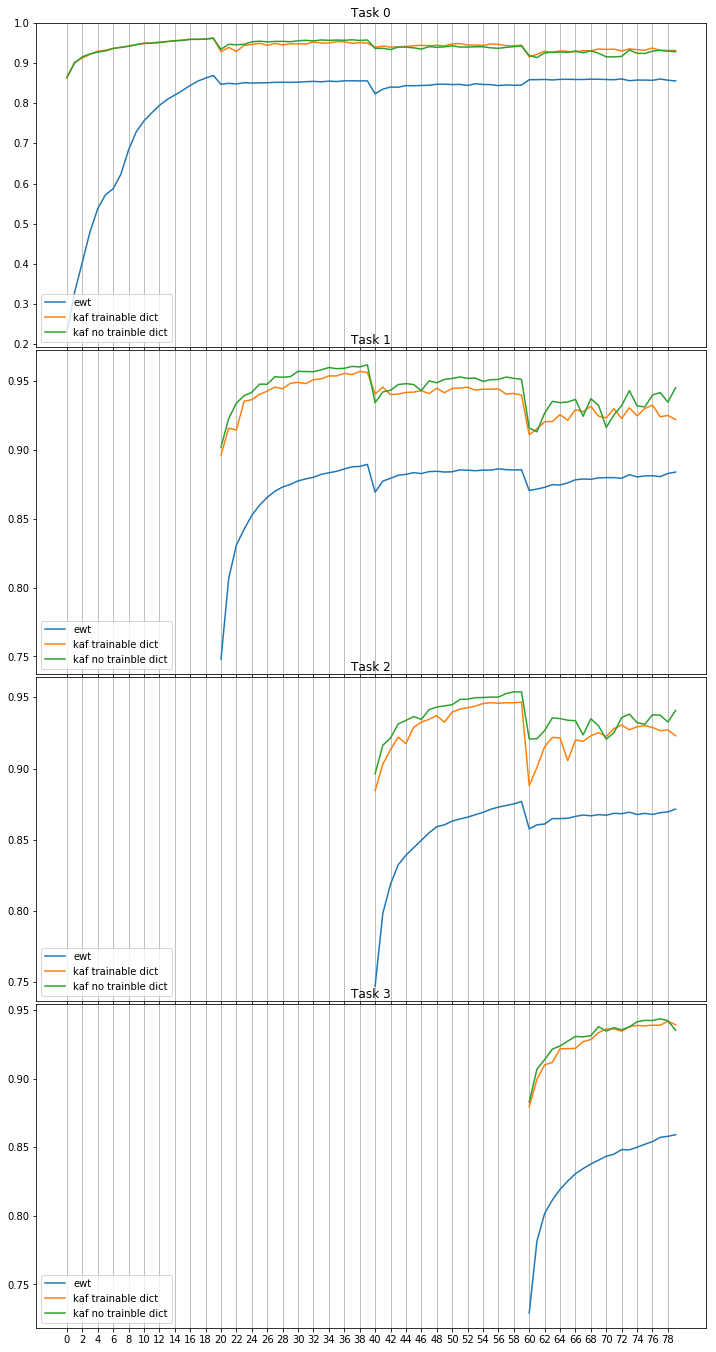

In [12]:
n_task = len(metrics_ewt['tasks'])
tot_epochs = 0

print('Online ewc', metrics_ewt['metrics'])

print('KAF no ewc', metrics_kaf_no_ewt['metrics'])
print('KAF online ewc', metrics_kaf_ewt['metrics'])

for k, v in metrics_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
             
for k, v in metrics_kaf_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig = plt.figure(figsize=(12, 24))

ax = None
for i, task in enumerate(metrics_ewt['tasks'].keys()):
        
    ewt = metrics_ewt['tasks'][task]    
    kaf_ewt = metrics_kaf_ewt['tasks'][task]
    kaf_no_ewt = metrics_kaf_no_ewt['tasks'][task]
    

    x = range(tot_epochs-len(ewt['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, ewt['f1'], label='ewt')
    ax.plot(x, kaf_ewt['f1'], label='kaf trainable dict')
    ax.plot(x, kaf_no_ewt['f1'], label='kaf no trainble dict')
    
    ax.set_xticks(list(range(0, tot_epochs, 2)), minor=False)
    
    ax.set_title("Task {}".format(task))
    ax.legend(loc="lower left")
    ax.grid(True, axis='x')
    
fig.subplots_adjust(hspace=0.01)


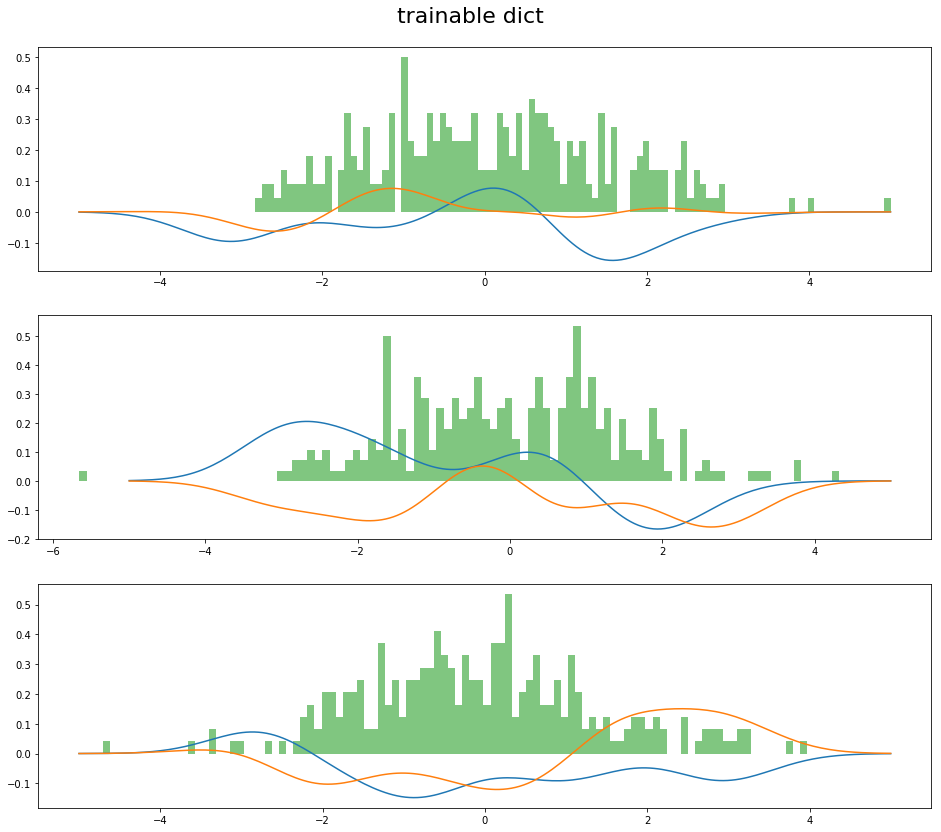

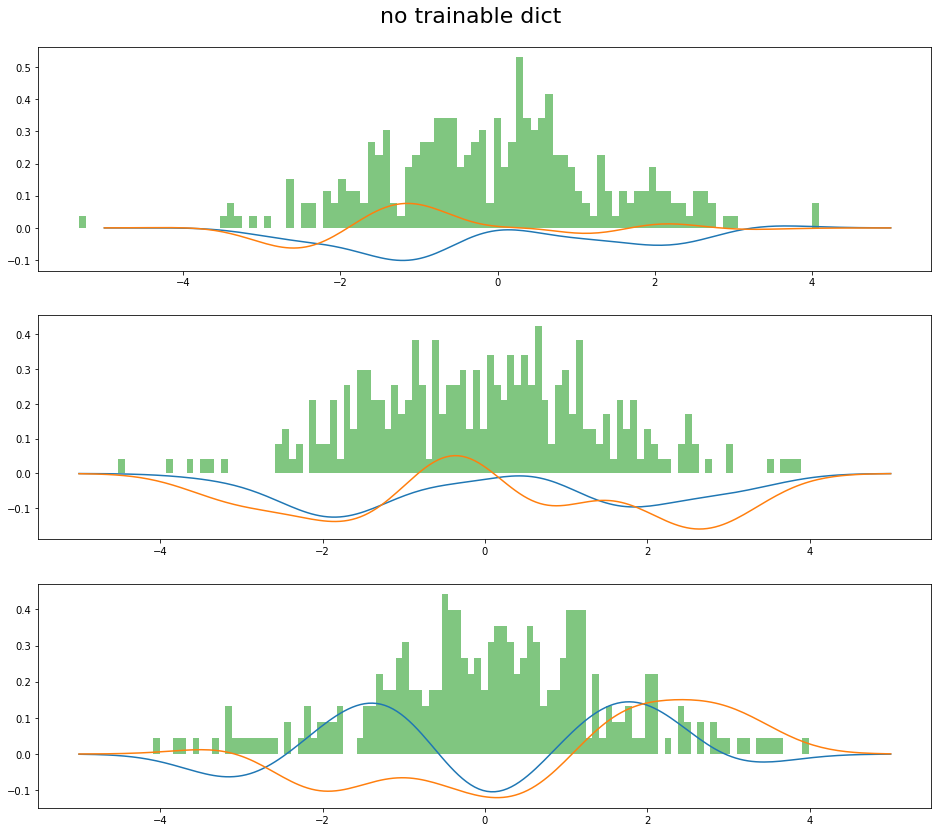

In [13]:
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)
    
x = list(range(20))
x = np.linspace(-5, 5, 100).astype(np.float32)
common_params = {'histtype': 'step'}
    
for trainer, t in [(trainer_kaf_ewt, 'trainable dict'), (trainer_kaf_no_ewt, 'no trainable dict')]:
    model = trainer.model
    fig, ax = plt.subplots(3, 1, sharex=False, figsize=(16, 14))
    fig.suptitle(t, size=22, y=0.92)
    
    for _, m in model.named_modules():
        m.register_forward_hook(hook)
        
    img = dataset[0][0]
    trainer.model(torch.Tensor(img).unsqueeze(0).cuda())
    
    hooked_params = dict(model.named_modules())
    
    for i in [1, 2, 3]:
        name = 'kaf'+str(i)

        c = []
        old = []
        
        for j in x:
            kaf = getattr(model, name)
            input = torch.Tensor([j]).unsqueeze(0).cuda()#.repeat(1, int(400*0.7), 1)
            res = kaf.forward(input).detach().cpu().numpy()[0]
            c.append(np.mean(res))
            
            res = getattr(old_kaf_ewt, name).cuda().forward(input).detach().cpu().numpy()[0]
            old.append(np.mean(res))

        spl = make_interp_spline(x, c, k=3)
        xnew = np.linspace(min(x), max(x), 200)
        ax[i-1].plot(xnew, spl(xnew))
        
        spl = make_interp_spline(x, old, k=3)
        ax[i-1].plot(xnew, spl(xnew))

        forward = hooked_params[name]._value_hook.detach().cpu().numpy()[0]
        ax[i-1].hist(x=forward, bins=100, histtype='stepfilled', density=True, alpha=0.6)
        #ax[i-1].set_xticks(x)


        
fig.subplots_adjust()
plt.show()
